In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log
import cv2
import os
from tqdm import tqdm
from scipy.spatial import Voronoi
from scipy import fftpack
from skimage.exposure import rescale_intensity
import networkx as nx
import sys
import cv2
import stemtool as st

code_path = os.path.abspath('utils/')

if code_path not in sys.path:
    sys.path.append(code_path)
    
from orientation_mapping import *
from graph_cut import *
from FFT_image_process import *
%matplotlib inline

def get_neighbor_length(vor,n,num_of_neighbors=6):
    vectors = get_neighbor_vectors(vor,n,num_of_neighbors)
    length = np.linalg.norm(vectors, axis=1)
    return length

def get_mask(vor,thres,neighbor_num=6):
    mask = np.ones(vor.points.shape[0])
    for i in range(vor.points.shape[0]):
        length = get_neighbor_length(vor,i,neighbor_num)
        if (length<thres).sum()<neighbor_num:
            mask[i] = 0
    return mask.astype(bool)
    
############ global parameters
median_interatomic_dist = 0
neighbor_num=6
epoch = 20
step = 1/200
max_bond_force = 10
beta = 20

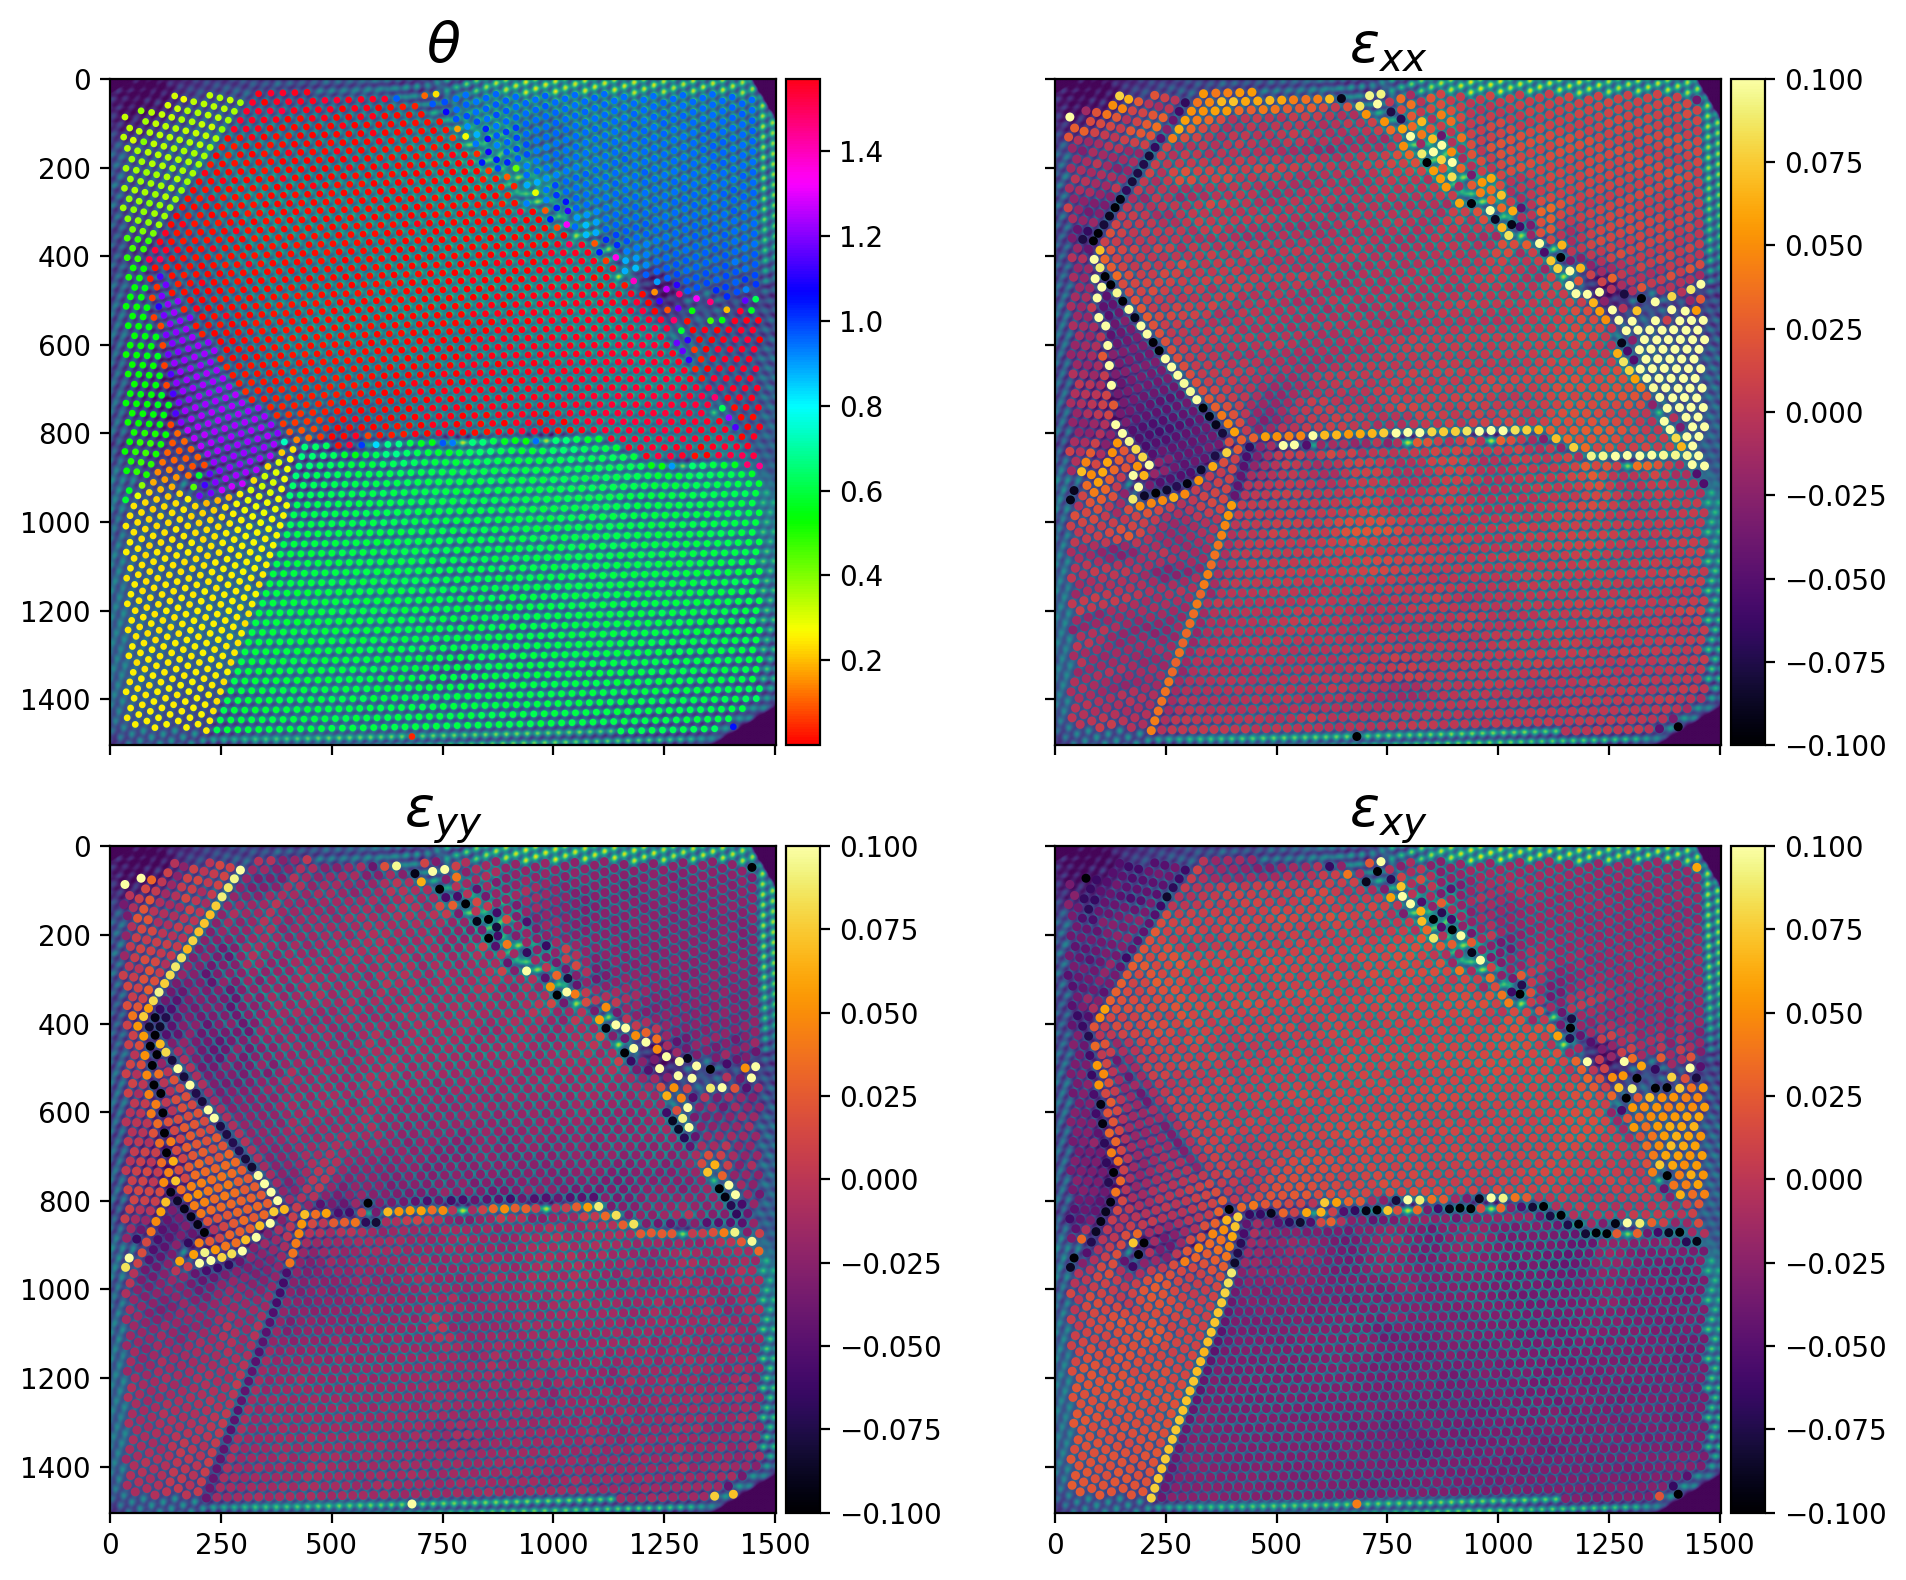

In [12]:
image = read_tiff_frame("data/video_strain.tif",0,1)
image = image_interpolation(image, 2)
Peak_position = get_peak_position(image, 10000)
Peak_start, Peak_end =  int(Peak_position*0.7), int(Peak_position*1.5) # begin and end of radial mask
im_filtered = rescale_intensity(fft_filtered_image(image, Peak_start, Peak_end), out_range=(0,255)).astype(np.uint8)
coordinates_all = coordinates_all = blob_log(im_filtered, min_sigma = 1,max_sigma = 10, threshold=6e-2, overlap=False, exclude_border=10)[:,:2]
vor = Voronoi(coordinates_all)
median_interatomic_dist = find_median_interatomic_dist(vor)
coordinates_all_refine = refine_atom_locs(image, coordinates_all, int(median_interatomic_dist//2))
img_template,fft_locs = template_map(image,Peak_end,select_area=True)
ideal_vectors, angle_ideal = get_template_factors(img_template,neighbor_num,neighbor_distance=median_interatomic_dist)

for frame in range(1,10):
    image = read_tiff_frame("data/video_strain.tif",frame,2)
    image = image_interpolation(image, 2)
    im_filtered = rescale_intensity(fft_filtered_image(image, Peak_start, Peak_end), out_range=(0,255)).astype(np.uint8)
    coordinates_all = coordinates_all = blob_log(im_filtered, min_sigma = 1,max_sigma = 10, threshold=6e-2, overlap=False, exclude_border=10)[:,:2]
    coordinates_all_refine = refine_atom_locs(image, coordinates_all, int(median_interatomic_dist//3))
    coordinates_all_gauss = np.zeros((coordinates_all_refine.shape[0], 7))
    st.afit.atom_positions.refine_atoms_numba(image, coordinates_all_refine,coordinates_all_gauss,median_interatomic_dist//2)
    vor = Voronoi(coordinates_all_gauss[:,:2])
    mask = get_mask(vor,median_interatomic_dist*2,neighbor_num)
    # G = get_graph_relaxation(coordinates_all_refine,num_of_neighbors=neighbor_num)
    # disp = lattice_relax(G, image, epoch, beta, step, max_bond_force, median_interatomic_dist=median_interatomic_dist, neighbor_num = neighbor_num)
    # coordinates_all_relax = np.array(list(nx.get_node_attributes(G, 'loc').values()))
    a,b,c,angles, RMSD = get_strain(coordinates_all_gauss[:,:2],ideal_vectors, angle_ideal, rotation_angle=0,
                                    return_error = True,num_of_neighbors=neighbor_num,angular_period=np.pi/2)
    plot_strain(image,coordinates_all_gauss[:,:2],angles,a,b,c,mask=mask,save_path=f'image/{frame}.jpg',plot_range=0.1)